In [11]:
import kagglehub

# Aufgabe 1
# Datensatz runterladen
path = kagglehub.dataset_download("naseralqaydeh/named-entity-recognition-ner-corpus")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\AFr\.cache\kagglehub\datasets\naseralqaydeh\named-entity-recognition-ner-corpus\versions\3


In [12]:
import pandas

# Datensatz einlesen
df = pandas.read_csv(path+ "\\"+"ner.csv")
sentences = df["Sentence"].tolist()
df.head()


,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [13]:
import spacy
!python -m spacy download en_core_web_sm
from spacy import displacy

# Aufgabe 2
# spaCy Pipeline die ersten 5 Sätze des Datensatzes einlesen
nlp = spacy.load("en_core_web_sm")
firstFive = "".join(sentences[:5])
doc = nlp(firstFive)
visualizer = displacy.render(doc, style="ent")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Thousands 0 9 CARDINAL
London 48 54 GPE
Iraq 77 81 GPE
British 111 118 NORP
Stop the Bombings 288 305 WORK_OF_ART
the Houses of Parliament 327 351 ORG
Hyde Park 366 375 LOC
10,000 414 420 CARDINAL
1,00,000 453 461 CARDINAL
annual 499 505 DATE
Britain 520 527 GPE
Labor Party 538 549 ORG
English 566 573 LANGUAGE
Brighton 592 600 GPE


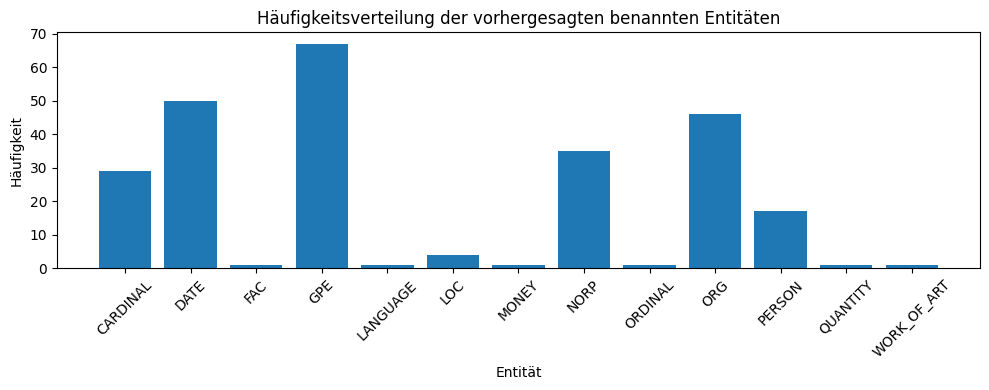

In [14]:
import matplotlib.pyplot as plt

# Aufgabe 3
# Häufigkeitsverteilung der vorhergesagten benannten Entitäten
firstHundred = "".join(sentences[:100])
doc = nlp(firstHundred)
entities = sorted({ent.label_ for ent in doc.ents})
frequencies = {label: 0 for label in entities}
for ent in doc.ents:
    frequencies[ent.label_] += 1
    
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(frequencies.keys(), frequencies.values())
ax.set_title("Häufigkeitsverteilung der vorhergesagten benannten Entitäten")
ax.set_xlabel("Entität")
ax.set_ylabel("Häufigkeit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import f1_score
import ast

# Erste 100 Sätze als eigenes DataFrame
sent_ids = df['Sentence #'].unique()[:100]
df100 = df[df['Sentence #'].isin(sent_ids)].copy()

# Labels mappen
def map_label(tag):
    if tag.endswith("geo") or tag.endswith("gpe"):
        return "GPE"
    elif tag.endswith("person"):
        return "PERSON"
    elif tag.endswith("organization"):
        return "ORG"
    else:
        return "O"

# Umwandlung String als Liste repräsentiert in tatsächliche Listen
df100['Tokens'] = df100['Sentence'].apply(lambda x: x.split())
df100['NER'] = df100['Tag'].apply(lambda x: ast.literal_eval(x))
df100['MappedNER'] = df100['NER'].apply(lambda tags: [map_label(t) for t in tags])

# Evaluation auf Token-level
label_true = []
label_pred = []

for sent_id in sent_ids:
    sent_df = df100[df100['Sentence #'] == sent_id]
    tokens = sent_df['Tokens'].iloc[0]
    true_labels = sent_df['MappedNER'].iloc[0]

    text = " ".join(tokens)
    doc = nlp(text)

    # Token-level vorrausgesagte Label
    pred_labels = [token.ent_type_ if token.ent_iob_ != "O" else "O" for token in doc]

    # Gegebenfalls kürzen, falls es eine leichte Abweichung gibt der Tokens
    if len(pred_labels) != len(true_labels):
        pred_labels = pred_labels[:len(true_labels)]

    label_true.extend(true_labels)
    label_pred.extend(pred_labels)

# F1-Score
f1 = f1_score(label_true, label_pred, labels=['GPE','PERSON','ORG'], average='micro')
print(f"spaCy F1-score: {f1:.3f}")


spaCy NER F1-score: 0.378
